# Energy-Based Diffusion Models

In the previous notebooks, we learned how standard diffusion models work: a neural network learns to predict and remove noise, enabling us to generate samples from random noise. These models are powerful for **generation**, but they have a limitation: they're essentially "black boxes" that can't directly tell us how "good" or "realistic" an arbitrary input is.

**Energy-Based Diffusion Models (EBMs)** address this limitation by learning an explicit **energy function** E(x, t) that assigns a scalar "energy" value to any input x at any noise level t. This single function gives us two powerful capabilities:

1. **Generation** (like standard diffusion): Follow the energy gradient to denoise samples
2. **Discrimination** (unique to EBMs): Score and rank arbitrary inputs based on their energy

The key insight from recent work like [ProteinEBM](https://arc.net/l/quote/kfekazck) is that **identifying good samples is easier than generating good ones**. By combining both capabilities, we can generate many candidates and use the energy function to select the best ones at the same time.

In this notebook, we'll:
- Understand the connection between energy, score, and probability
- Implement an energy-based diffusion model on our 2D spiral dataset
- Visualize energy landscapes at different noise levels
- Explore the discriminative capabilities: scoring, ranking, and filtering samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Preparing Our Data

We'll start with the same 2D spiral dataset from the first notebook. This simple dataset allows us to visualize energy landscapes in 2D, making it easier to understand how the energy function captures the structure of the data distribution.


In [2]:
def plot_data(data, title=None):
    # plot initial data
    plt.figure(figsize=(6,6))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.6, c='purple')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def get_spiral_data(n_points=1000):
    theta = np.sqrt(np.random.rand(n_points)) * 720 * (np.pi / 180)
    r = 0.5 * theta 
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    data = np.stack([x, y], axis=1) + np.random.randn(n_points, 2) * 0.3
    data_max = np.max(np.abs(data))
    data = data / data_max
    return data.astype(np.float32)


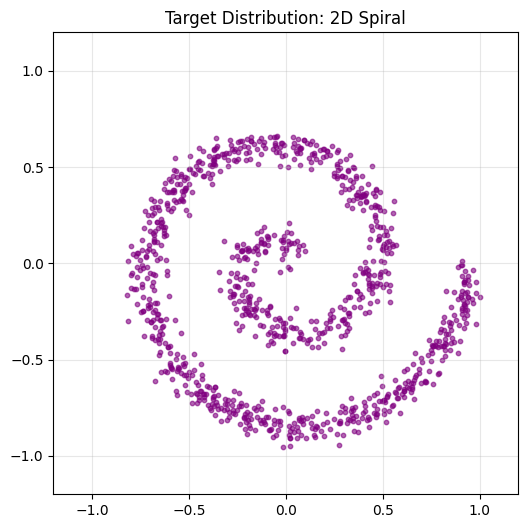

In [3]:
data = get_spiral_data()
plot_data(data, title="Target Distribution: 2D Spiral")

In [4]:
def forward_diffusion_step(x, t, betas):
    # sample gaussian noise
    noise = torch.randn_like(x)
    # get beta for current timestep
    b_t = betas[t]
    # add noise to x (forward diffusion)
    x_t = torch.sqrt(1-b_t) * x + torch.sqrt(b_t) * noise
    
    return x_t
    
def forward_diffusion(x, diffusion_steps, betas):
    x_values = [x]
    for i in range(diffusion_steps):
        x_t = forward_diffusion_step(x, i, betas)
        x_values.append(x_t)
        x = x_t
    return x, x_values

In [5]:
def sample_t(x_0, t, alpha_bars):
    # sample noise
    epsilon = torch.randn_like(x_0)
    # get x_t using closed form equation
    x_t = torch.sqrt(alpha_bars[t]) * x_0 + torch.sqrt(1-alpha_bars[t]) * epsilon
    
    return x_t, epsilon

In [6]:
@torch.no_grad()
def sample(model, x_t, alpha_t, alpha_bar_t, sigma_t, t):
    epsilon = model(x_t, t)
    if t.numel() > 1:
        is_zero_timestep = (t[0] == 0)
    else:
        is_zero_timestep = (t.item() == 0)
        
    if is_zero_timestep:
        z = torch.zeros_like(x_t)
    else:
        z = torch.randn_like(x_t)
    x_prev = 1/torch.sqrt(alpha_t) * (x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * epsilon) + sigma_t * z
    
    return x_prev

@torch.no_grad()
def reverse_diffusion(model, x_t, timesteps, device):  
    betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
    alphas = 1-betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    batch_size = x_t.shape[0]  # Get the batch size
    
    model.eval()
    for t in range(timesteps-1, -1, -1):
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        sigma_t = torch.sqrt(betas[t])
        # Expand t to match batch size
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        x_prev = sample(model, x_t, alpha_t, alpha_bar_t, sigma_t, t_batch)
        x_t = x_prev
    return x_t
    

## The generative process


### Forward Diffusion: VP-SDE Parameterization

Before we define our energy network, let's set up the forward diffusion process. We'll use the **Variance-Preserving SDE (VP-SDE)** parameterization, which is what ProteinEBM uses.

**Why VP-SDE?**

In the basic DDPM formulation we saw before, we used discrete timesteps with a fixed schedule. The VP-SDE formulation is a continuous-time version that:
- Provides smoother noise schedules
- Works better for continuous physical systems (like proteins)
- Has nice mathematical properties for score computation

**The Noise Schedule:**

$$\beta(t) = \beta_{\text{min}} + t \cdot (\beta_{\text{max}} - \beta_{\text{min}})$$

The marginal variance at time $t$ is:
$$\sigma^2(t) = 1 - \exp\left(-\int_0^t \beta(s) ds\right)$$

This gives us the forward sampling equation:
$$x_t = \sqrt{1 - \sigma^2(t)} \cdot x_0 + \sigma(t) \cdot \epsilon$$


In [7]:
# VP-SDE parameterization
# β(t) = min_b + t*(max_b - min_b)  (linear schedule)
# Marginal variance: σ²(t) = 1 - exp(-∫β(s)ds) = 1 - exp(-marginal_b_t)

min_b = 0.1
max_b = 20.0

def marginal_b_t(t):
    """Integrated noise schedule"""
    return t * min_b + 0.5 * (t**2) * (max_b - min_b)

def forward_marginal_vpsde(x_0, t):
    """Sample x_t ~ p(x_t | x_0) for VP-SDE"""
    mean_coef = torch.exp(-0.5 * marginal_b_t(t))
    var = 1 - torch.exp(-marginal_b_t(t))
    noise = torch.randn_like(x_0)
    x_t = mean_coef * x_0 + torch.sqrt(var) * noise
    return x_t, noise

## The Energy-Based Approach: A Fundamental Shift

Now we arrive at the core difference between standard diffusion and energy-based diffusion. Let's understand the key concepts:

### Energy, Score, and Probability: The Holy Trinity

These three quantities are mathematically linked:

**Probability Density:**
$$p(x) \propto \exp(-E(x))$$

**Log-Probability:**
$$\log p(x) = -E(x) - \log Z$$

**Score Function:**
$$s(x) = \nabla_x \log p(x) = -\nabla_x E(x)$$

The **score** is the gradient of log-probability: it points in the direction of increasing probability (decreasing energy). This is the key connection:
- If you know the energy, you know the score (via gradient)
- If you know the score, you can sample (via the reverse diffusion process we learned)

### Standard Diffusion vs EBM Diffusion

**Standard Approach (DDPM):**
- Network directly outputs: $\hat{\epsilon}(x_t, t)$ (predicted noise)
- Training: MSE between predicted and true noise
- Sampling: Use predicted noise to reverse the diffusion
- **Limitation:** No energy function. You can generate, but can't score arbitrary inputs

**EBM Approach:**
- Network outputs: $E_\theta(x_t, t)$ (energy)
- Score is derived: $s_\theta(x_t, t) = -\nabla_x E_\theta(x_t, t)$
- Training: Same MSE loss, but on the derived score
- Sampling: Same reverse diffusion, using the derived score
- **Advantage:** You get both generation AND scoring!

### The Energy Parameterization: ||r(x,t)||²

A crucial design choice is how to parameterize the energy. In our case, we use:

$$E_\theta(x, t) = \sum_i ||r_i(x, t)||^2$$

Where $r_i$ is a vector output for each component (dimension of our input).

**Why squared norm?**
1. **Always non-negative**: Energy is bounded below
3. **Interpretable output**: The vector $r$ can be thought of as a "correction direction". Its magnitude indicates how far from the data manifold we are

Let's implement this energy-based network:


In [8]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

In [9]:
class EnergyNetwork(nn.Module):
    """
    Energy-based network for diffusion.
    Instead of predicting noise, outputs a vector whose squared norm is the energy.
    """
    def __init__(self, sample_dim=2, time_embedding_dim=64, hidden_dim=256):
        super().__init__()
        
        self.time_embedder = SinusoidalEmbedding(time_embedding_dim)
        
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.input_proj = nn.Linear(sample_dim, hidden_dim)
        
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ) for _ in range(3)
        ])
        
        # Output same dimension as input (for energy = ||output||²)
        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, sample_dim),  # Match input dim
        )
        
    def forward(self, x, t):
        """Returns the 'r_update' vector (ProteinEBM terminology)"""
        t_emb = self.time_embedder(t)
        t_emb = self.time_mlp(t_emb)
        
        h = self.input_proj(x)
        h = h + t_emb
        
        for block in self.blocks:
            h = h + block(h)
        
        return self.output_proj(h)
    
    def compute_energy(self, x, t):
        """Energy = sum of squared output"""
        r_update = self.forward(x, t)
        energy = (r_update ** 2).sum(dim=-1)  # [batch_size]
        return energy, r_update
    
    def compute_score(self, x, t):
        """Score = -∇_x E(x, t) via autograd"""
        x = x.requires_grad_(True)
        energy, r_update = self.compute_energy(x, t)
        
        # Compute gradient of energy w.r.t. x
        grad_energy = torch.autograd.grad(
            energy.sum(), x, create_graph=True
        )[0]
        
        score = -grad_energy  # Score is negative gradient
        return score, energy, r_update

We make our spiral dataset such that within each batch we have a number of random noised samples, picked with the trick for forward diffusion we saw before.

### Training the Energy-Based Model

The training process for an EBM follows the same principle as standard diffusion models: **denoising score matching**. However, instead of training a network to directly predict noise, we train it such that the score derived from its energy matches the true score.

**The Training Loss:**

We train our model so that its derived score matches this ground truth:
$$\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| s_\theta(x_t, t) - \left( -\frac{\epsilon}{\sqrt{1 - \bar{\alpha}_t}} \right) \|^2 \right]$$

For an EBM, $s_\theta(x_t, t) = -\nabla_x E_\theta(x_t, t)$, computed via automatic differentiation.

**What Does This Achieve?**

As training converges, the learned energy $E_\theta(x, t)$ approaches $-\log p_t(x) +$ constant, where $p_t(x)$ is the data distribution convolved with noise level $t$. At low $t$, this approximates the true data distribution.

**The Trade-off:**

EBM training requires computing gradients through the network (second-order derivatives), making it slower than standard diffusion. But we gain an interpretable energy landscape and the ability to score arbitrary inputs!

Let's set up the training:


In [10]:
class SpiralDataset(Dataset):
    def __init__(self, n_points=1000, timesteps = 200):
        self.data = get_spiral_data(n_points)
        # plot initial data
        plot_data(self.data, title="Training Data: 2D Spiral")
        self.timesteps = timesteps
        self.alpha_bars = torch.cumprod(1-torch.linspace(1e-4, 0.02, timesteps), dim=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # sample a random timestep
        t = torch.randint(0, self.timesteps, (1,)).item()
        # get the data point
        x_0 = torch.tensor(self.data[index]).float()
        # get x_t and epsilon using the forward diffusion trick
        x_t, epsilon = sample_t(x_0, torch.tensor(t), self.alpha_bars)
        
        return x_t, t, epsilon
    

Using device: mps


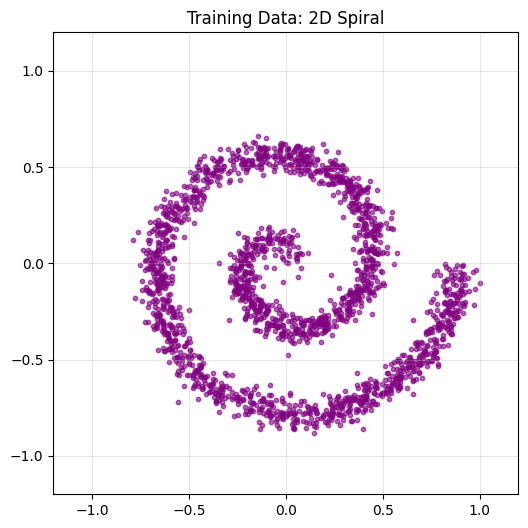

In [11]:
# Setup (same structure as original)
timesteps = 300
n_points = 2000

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Dataset & DataLoader (reuse the exact same SpiralDataset!)
dataset = SpiralDataset(n_points=n_points, timesteps=timesteps)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# Model (our new EBM version instead of DenoiserNetwork)
model = EnergyNetwork(sample_dim=2, time_embedding_dim=32, hidden_dim=256)
model.to(device)

# Optimizer & Loss (same as original)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

# Precompute alpha_bars for converting epsilon -> score
alpha_bars = torch.cumprod(1 - torch.linspace(1e-4, 0.02, timesteps), dim=0).to(device)

In [12]:
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for x_t, t, epsilon in dataloader:
        x_t = x_t.to(device)
        t = t.to(device)
        epsilon = epsilon.to(device)
        
        alpha_bar_t = alpha_bars[t]
        noise_variance = 1 - alpha_bar_t  # σ²(t)
        
        # Ground truth score
        gt_score = -epsilon / torch.sqrt(noise_variance).unsqueeze(-1)
        
        # Predicted score from EBM
        pred_score, energy, r_update = model.compute_score(x_t, t)
        
        # WEIGHTED loss - multiply by variance to normalize
        # This is equivalent to: loss = ||pred_epsilon - epsilon||²
        score_diff_sq = (pred_score - gt_score) ** 2
        weighted_loss = (noise_variance.unsqueeze(-1) * score_diff_sq).mean()
        
        loss = weighted_loss
        
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1} loss: {avg_loss:.6f}")

Epoch 50 loss: 0.293357
Epoch 100 loss: 0.269377
Epoch 150 loss: 0.276366
Epoch 200 loss: 0.248638
Epoch 250 loss: 0.256105
Epoch 300 loss: 0.264174
Epoch 350 loss: 0.258130
Epoch 400 loss: 0.278654
Epoch 450 loss: 0.267722
Epoch 500 loss: 0.266617
Epoch 550 loss: 0.262628
Epoch 600 loss: 0.270164
Epoch 650 loss: 0.254588
Epoch 700 loss: 0.259223
Epoch 750 loss: 0.250226
Epoch 800 loss: 0.262489
Epoch 850 loss: 0.266987
Epoch 900 loss: 0.239844
Epoch 950 loss: 0.255859
Epoch 1000 loss: 0.267521


### Step 3: Visualizing Time-Dependent Energy Landscapes

One of the most powerful features of EBMs is that we can **visualize** the energy function. Since our spiral dataset lives in 2D, we can plot $E(x, t)$ as a heatmap and see how the energy landscape changes with the diffusion timestep.

**Time-Dependent Energy Hierarchy**

The energy $E_\theta(x, t)$ is a function of both position $x$ AND diffusion time $t$. This creates a family of energy landscapes:

**High $t$ (e.g., t = 200-290)**
- The landscape is smooth and broad
- Roughly Gaussian-shaped (since heavily noised data looks Gaussian)
- Useful for global structure and initial sampling steps

**Medium $t$ (e.g., t = 50-150)**
- The landscape shows the data structure
- Low-energy valleys follow the data manifold
- **This is the sweet spot for scoring/ranking**
- Useful for evaluating sample quality

**Low $t$ (e.g., t = 10-20)**
- Very sharp landscape, concentrated on the manifold
- Only "knows about" regions very close to real data
- Useful for fine-grained local corrections

This coarse-to-fine hierarchy is why diffusion models work: you traverse from high $t$ to low $t$, following the score at each level, naturally progressing from global structure to fine details.

Let's visualize these energy landscapes:


In [66]:
def plot_energy_landscapes_over_time(model, timesteps_to_plot, data=None, device='cpu', grid_size=80):
    """
    Plot energy landscapes at multiple time steps to see evolution.
    
    Args:
        model: trained EnergyNetwork
        timesteps_to_plot: list of time steps to visualize
        data: optional training data to overlay
        device: torch device
        grid_size: resolution of the grid
    """
    model.eval()
    
    n_plots = len(timesteps_to_plot)
    # Slightly taller figure so we can fit a bottom colorbar without shrinking subplots too much
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 4.8))
    
    if n_plots == 1:
        axes = [axes]
    
    # Create grid once (reuse for all time steps)
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    # Compute energy for each time step
    all_energies = []
    for t_value in timesteps_to_plot:
        t_batch = torch.full((grid_points.shape[0],), t_value, device=device, dtype=torch.long)
        with torch.no_grad():
            energy, _ = model.compute_energy(grid_points, t_batch)
        all_energies.append(energy.cpu().reshape(grid_size, grid_size))
    
    # Find global min/max for consistent colormap
    vmin = min(e.min() for e in all_energies)
    vmax = max(e.max() for e in all_energies)
    
    # Plot each time step
    for ax, t_value, energy_grid in zip(axes, timesteps_to_plot, all_energies):
        contour = ax.contourf(
            xx.numpy(), yy.numpy(), energy_grid.numpy(),
            levels=50, cmap='viridis', vmin=vmin, vmax=vmax
        )
        
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.3, c='red')
        
        ax.set_title(f't = {t_value}')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    # Title + spacing: give extra vertical room for a dedicated bottom colorbar
    fig.suptitle('Energy Landscape Evolution Over Diffusion Time', y=0.96)
    fig.subplots_adjust(bottom=0.22, top=0.92, wspace=0.35)

    # Dedicated colorbar axis (prevents overlap without shrinking the subplots)
    cax = fig.add_axes([0.20, 0.10, 0.60, 0.04])  # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(contour, cax=cax, orientation='horizontal')
    cbar.set_label('Energy E(x, t)')

    plt.show()
    
    model.train()

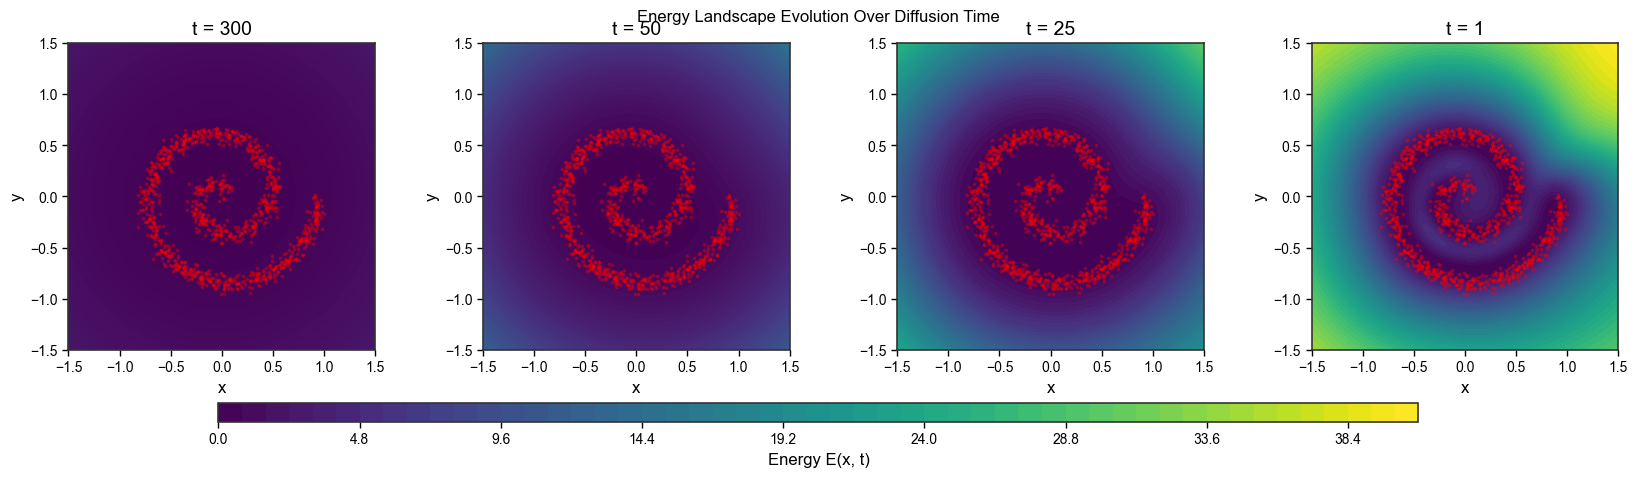

In [67]:
# Plot energy landscapes at different noise levels
# Low t = clean data, High t = noisy data
plot_energy_landscapes_over_time(
    model, 
    timesteps_to_plot=[300, 50, 25, 1], 
    data=data, 
    device=device
)

### Step 4: Generation via the Score Vector Field

Now let's use our trained energy function for generation. The key insight is that the score $s(x, t) = -\nabla_x E(x, t)$ defines a **vector field** over the input space. At each point, the score tells us "which direction leads to higher probability (lower energy)?"

**Langevin Dynamics and Reverse Diffusion:**

The reverse diffusion process is essentially Langevin dynamics with a time-varying energy:
$$x_{t-\Delta t} = x_t + \text{(drift toward low energy at level } t\text{)} + \text{noise}$$

At each step, we follow the score (negative energy gradient) to move toward higher-probability regions for that noise level.

Let's implement reverse diffusion using our EBM score:


In [68]:
# First, the helper functions (from earlier)

def langevin_step(model, x_t, t, alpha_t, alpha_bar_t, sigma_t):
    """
    One step of reverse diffusion using EBM score.
    Mirrors the structure of the original 'sample' function.
    """
    # Get score from EBM (need gradients for this)
    with torch.enable_grad():
        x_t_input = x_t.detach().requires_grad_(True)
        score, energy, r_update = model.compute_score(x_t_input, t)
        score = score.detach()
    
    # Check if final step (same logic as original)
    if t.numel() > 1:
        is_zero_timestep = (t[0] == 0)
    else:
        is_zero_timestep = (t.item() == 0)
    
    if is_zero_timestep:
        z = torch.zeros_like(x_t)
    else:
        z = torch.randn_like(x_t)
    
    # Reverse step using score (instead of epsilon)
    # Original: x_prev = 1/sqrt(α_t) * (x_t - (1-α_t)/sqrt(1-ᾱ_t) * ε) + σ_t * z
    # With score: since score = -ε/sqrt(1-ᾱ_t), we have ε = -score * sqrt(1-ᾱ_t)
    # So: x_prev = 1/sqrt(α_t) * (x_t + (1-α_t) * score) + σ_t * z
    
    x_prev = (1 / torch.sqrt(alpha_t)) * (x_t + (1 - alpha_t) * score) + sigma_t * z
    
    return x_prev


@torch.no_grad()
def reverse_diffusion_ebm(model, x_t, timesteps, device):
    """
    Full reverse diffusion using EBM.
    Same structure as original reverse_diffusion function.
    """
    betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    batch_size = x_t.shape[0]
    
    model.eval()
    for t in range(timesteps - 1, -1, -1):
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        sigma_t = torch.sqrt(betas[t])
        
        # Expand t to match batch size
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        x_prev = langevin_step(model, x_t, t_batch, alpha_t, alpha_bar_t, sigma_t)
        x_t = x_prev
        
    return x_t

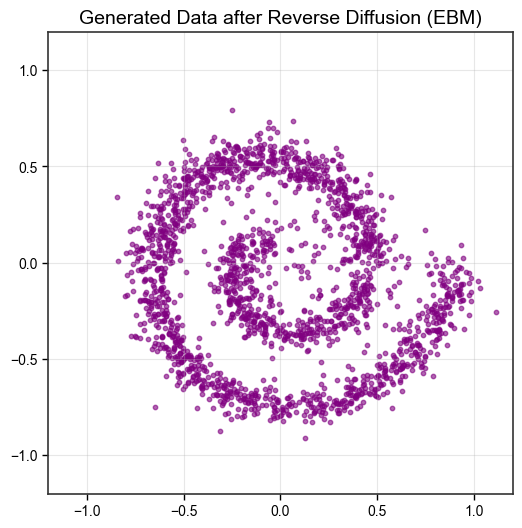

In [71]:
# Generation code (same structure as original notebook)

# 1. Generate pure noise
x_T = torch.randn(n_points, 2).to(device)

# 2. Run the reverse process
# This might take a bit longer than original due to gradient computation
generated_data = reverse_diffusion_ebm(model, x_T, timesteps, device=device)

# 3. Plot the result
generated_data = generated_data.cpu().numpy()

plot_data(generated_data, title="Generated Data after Reverse Diffusion (EBM)")

Let's make a first sanity check: we know that samples with a low energy correspond to the ones having the highest probability of being within distribution. In this example we pass to the model samples from the training data and samples generated randomly. We expect that our model learned to assign to training samples (target distribution samples) a much lower score with respect to random ones.

In [72]:
def score_samples(model, samples, t=0.1):
    """Use EBM to score quality of samples"""
    t_batch = torch.full((samples.shape[0],), t, device=samples.device)
    with torch.no_grad():
        energies, _ = model.compute_energy(samples, t_batch)
    return energies

# Score training data vs random noise
train_energies = score_samples(model, torch.tensor(data).float().to(device))
noise_energies = score_samples(model, torch.randn(1000, 2).to(device))

print(f"Training data energy: {train_energies.mean():.2f} ± {train_energies.std():.2f}")
print(f"Random noise energy: {noise_energies.mean():.2f} ± {noise_energies.std():.2f}")

Training data energy: 1.19 ± 0.94
Random noise energy: 16.48 ± 13.01


### Visualizing the Score Vector Field

The score $s(x, t) = -\nabla_x E(x, t)$ defines a **vector field** over the input space. At each point, the arrow points in the direction of increasing probability (decreasing energy).

**Why Visualize the Vector Field?**

1. **Understand the dynamics**: See how samples flow during reverse diffusion
2. **Check for curl**: EBM scores are curl-free (conservative), which provides stable dynamics
3. **Identify attractors**: Strong arrows pointing inward show where the data manifold is
4. **Compare time scales**: See how the field evolves from smooth (high $t$) to sharp (low $t$)

Let's create a combined visualization showing both the energy landscape and the score vector field:


In [73]:
def plot_energy_and_vector_field(model, t_value, data=None, device='cpu', 
                                  grid_size=100, arrow_grid_size=20):
    """
    Visualize energy landscape and score vector field side by side.
    
    Args:
        model: trained EnergyNetwork
        t_value: timestep
        data: optional training data to overlay
        device: torch device
        grid_size: resolution for energy heatmap
        arrow_grid_size: resolution for vector field (coarser for readability)
    """
    model.eval()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ============ LEFT: Energy Landscape ============
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    t_batch = torch.full((grid_points.shape[0],), t_value, device=device, dtype=torch.long)
    
    with torch.no_grad():
        energy, _ = model.compute_energy(grid_points, t_batch)
    
    energy_grid = energy.cpu().reshape(grid_size, grid_size)
    
    # Plot energy heatmap
    contour = axes[0].contourf(xx.numpy(), yy.numpy(), energy_grid.numpy(), 
                                levels=50, cmap='viridis')
    fig.colorbar(contour, ax=axes[0], label='Energy E(x, t)')
    
    if data is not None:
        axes[0].scatter(data[:, 0], data[:, 1], s=5, alpha=0.4, c='red', label='Data')
        axes[0].legend()
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title(f'Energy Landscape (t={t_value})')
    axes[0].set_xlim(-1.5, 1.5)
    axes[0].set_ylim(-1.5, 1.5)
    axes[0].set_aspect('equal')
    
    # ============ RIGHT: Vector Field (Score) ============
    x_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    y_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    xx_arrow, yy_arrow = torch.meshgrid(x_arrow, y_arrow, indexing='ij')
    arrow_points = torch.stack([xx_arrow.flatten(), yy_arrow.flatten()], dim=1).to(device)
    t_arrow = torch.full((arrow_points.shape[0],), t_value, device=device, dtype=torch.long)
    
    # Compute score (need gradients)
    arrow_points_grad = arrow_points.detach().requires_grad_(True)
    energy_arrow, _ = model.compute_energy(arrow_points_grad, t_arrow)
    
    grad_energy = torch.autograd.grad(energy_arrow.sum(), arrow_points_grad)[0]
    score = -grad_energy  # Score = -∇E
    
    # Reshape for quiver
    score_x = score[:, 0].detach().cpu().reshape(arrow_grid_size, arrow_grid_size).numpy()
    score_y = score[:, 1].detach().cpu().reshape(arrow_grid_size, arrow_grid_size).numpy()
    
    # Compute magnitude for coloring
    magnitude = np.sqrt(score_x**2 + score_y**2)
    
    # Normalize arrows for visibility (optional)
    norm_factor = np.maximum(magnitude, 1e-8)
    score_x_norm = score_x / norm_factor * 0.1  # Scale for visibility
    score_y_norm = score_y / norm_factor * 0.1
    
    # Plot vector field with magnitude coloring
    quiver = axes[1].quiver(
        xx_arrow.numpy(), yy_arrow.numpy(), 
        score_x_norm, score_y_norm,
        magnitude,  # Color by magnitude
        cmap='plasma',
        alpha=0.8
    )
    fig.colorbar(quiver, ax=axes[1], label='Score Magnitude')
    
    if data is not None:
        axes[1].scatter(data[:, 0], data[:, 1], s=5, alpha=0.4, c='lime', label='Data')
        axes[1].legend()
    
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_title(f'Score Vector Field s(x,t) = -∇E (t={t_value})')
    axes[1].set_xlim(-1.5, 1.5)
    axes[1].set_ylim(-1.5, 1.5)
    axes[1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

/var/folders/t4/bjm8mgw92d53x5w4s4hbgbww0000gn/T/ipykernel_26987/1106630918.py:92: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.tight_layout()


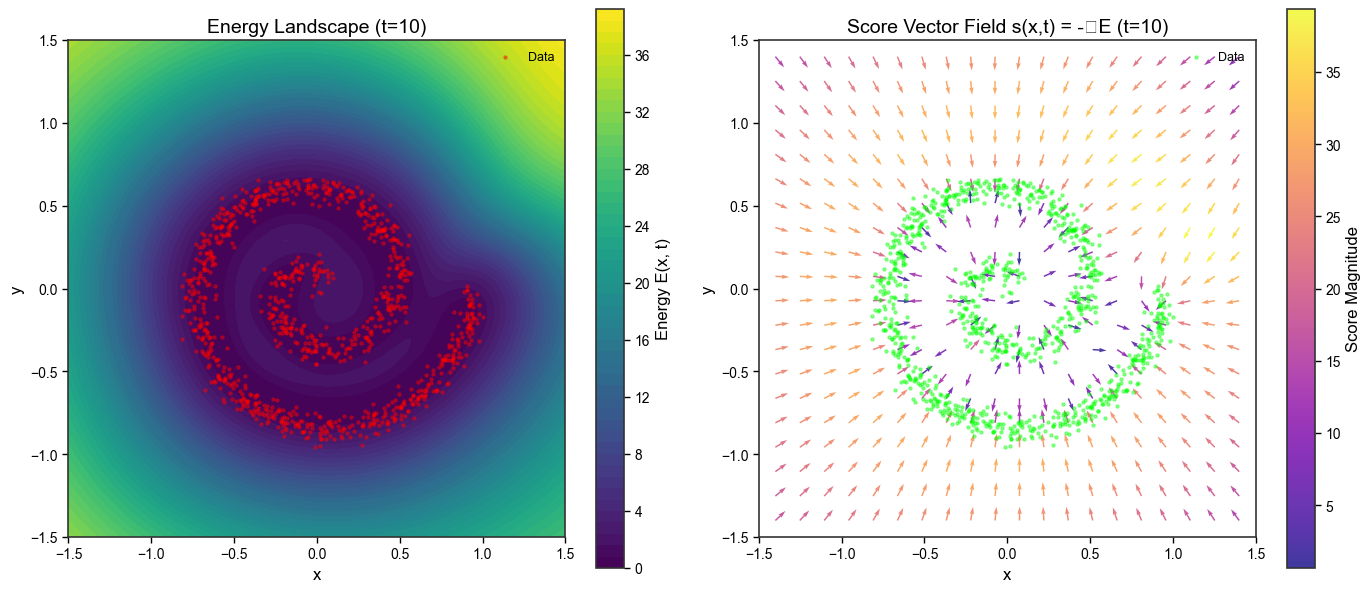

In [75]:
# Visualize at different timesteps
plot_energy_and_vector_field(model, t_value=10, data=data, device=device)

## Scoring and Ranking

Now we arrive at the **fundamental advantage** of EBMs over standard diffusion models: the ability to **score arbitrary inputs**, not just generate them.

### The Two Capabilities: Generation and Discrimination

**Generation (shared with standard diffusion):**
- Start from noise
- Follow the score to reverse the diffusion
- End with a sample from the data distribution

**Discrimination (unique to EBMs):**
- Take any input $x$
- Compute $E(x, t)$ at an appropriate $t$
- Use energy to:
  - Rank multiple candidates (lower energy = better)
  - Filter bad samples (reject if energy > threshold)
  - Score quality without ground truth
  - Detect out-of-distribution inputs (high energy)

### Why Scoring Works Better Than Generation

A key insight from ProteinEBM: the **discriminative energy is more accurate than the generative sampling**.

**Why?**
1. **Sampling accumulates errors**: Reverse diffusion involves hundreds of sequential steps. Errors compound.
2. **Scoring is a single evaluation**: You just compute $E(x, t)$ once. No error accumulation.
3. **The model sees more training signal for discrimination**: At each training step, the model learns "this noised sample should have this score." It's directly learning to evaluate.
4. **Coverage vs. accuracy**: The sampler might not explore all modes of the distribution. But the energy function, once learned, should correctly score samples from any mode, even ones the sampler rarely visits.

This is why ProteinEBM's strategy works: **generate many samples** (cast a wide net), then **rank by energy** (select the best). The energy catches good structures that the sampler found by chance.

Let's explore the discriminative capabilities of our trained EBM:


### Ranking Generated Samples: Finding the Best Ones

We can generate many samples and then use the energy function to identify the best ones. 
**The Strategy:**
- Generate $N$ samples from the model
- Compute $E(x_i, t)$ for each sample at a fixed $t$ (e.g., $t=10$)
- Sort by energy: lowest energy = best quality
- Select the top-$k$ samples

**Why This Works:**
The energy function is often more reliable than the sampler itself. The sampler explores stochastically and might produce some "lucky" good samples mixed with mediocre ones. The energy function can identify which are which!


In [85]:
# =============================================================================
# RANKING GENERATED SAMPLES - Find the best ones!
# =============================================================================
# We can generate many samples for a spiral and select the best ones by energy.

def generate_and_rank(model, n_samples, timesteps, device, t_score=10):
    """
    Generate samples and rank them by energy.
    Returns samples sorted from lowest (best) to highest (worst) energy.
    """
    model.eval()
    
    # Generate
    x_T = torch.randn(n_samples, 2).to(device)
    samples = reverse_diffusion_ebm(model, x_T, timesteps, device=device)
    
    # Score
    energies = score_samples(model, samples, t_value=t_score, device=device)
    
    # Sort by energy (ascending = best first)
    sorted_indices = torch.argsort(energies)
    sorted_samples = samples.cpu()[sorted_indices]
    sorted_energies = energies[sorted_indices]
    
    return sorted_samples, sorted_energies

# Generate and rank 1000 samples
ranked_samples, ranked_energies = generate_and_rank(model, 1000, timesteps, device, t_score=10)

print("Top 10 samples (lowest energy):")
print(ranked_energies[:10].numpy())
print("\nBottom 10 samples (highest energy):")
print(ranked_energies[-10:].numpy())

Top 10 samples (lowest energy):
[0.00291306 0.00571111 0.0096039  0.0099676  0.01128503 0.01167997
 0.01702083 0.01871387 0.01915253 0.01918429]

Bottom 10 samples (highest energy):
[2.1738534 2.207155  2.2575903 2.319808  2.4082706 2.6644478 2.838777
 3.433811  3.9391418 4.4465055]


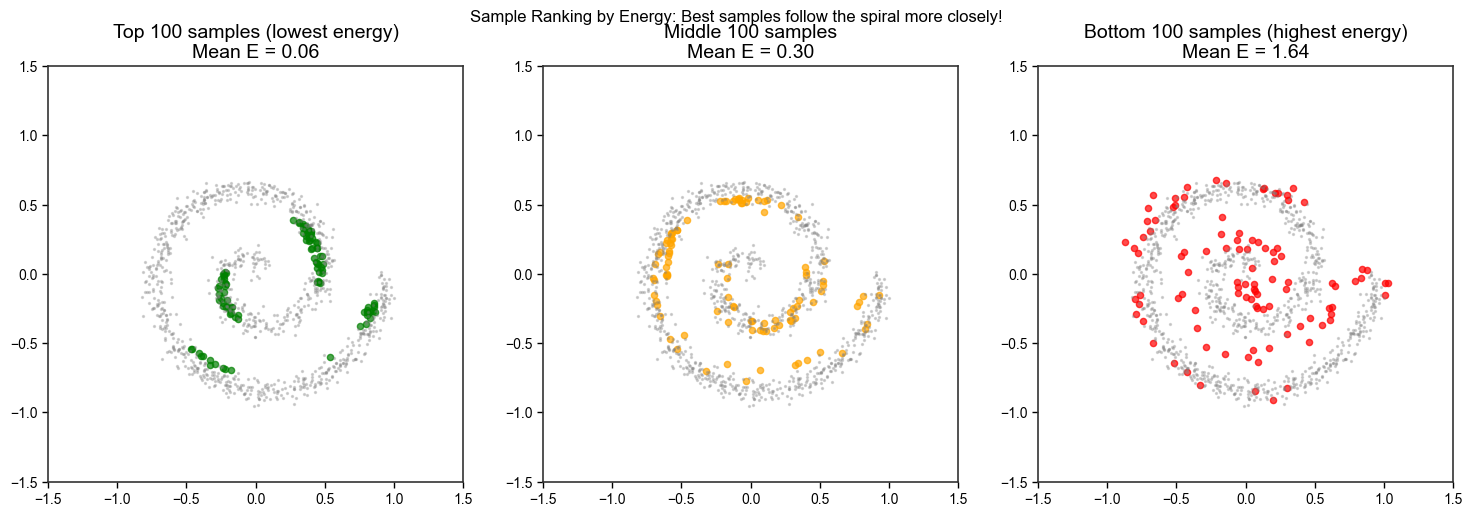

In [86]:
# Visualize: Best vs Worst samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Best 10%
n_top = 100
axes[0].scatter(ranked_samples[:n_top, 0], ranked_samples[:n_top, 1], 
               s=20, c='green', alpha=0.7)
axes[0].scatter(data[:, 0], data[:, 1], s=2, c='gray', alpha=0.3, label='Training data')
axes[0].set_title(f'Top {n_top} samples (lowest energy)\nMean E = {ranked_energies[:n_top].mean():.2f}')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_aspect('equal')

# Middle 10%
mid_start = len(ranked_samples) // 2 - n_top // 2
axes[1].scatter(ranked_samples[mid_start:mid_start+n_top, 0], 
               ranked_samples[mid_start:mid_start+n_top, 1], 
               s=20, c='orange', alpha=0.7)
axes[1].scatter(data[:, 0], data[:, 1], s=2, c='gray', alpha=0.3)
axes[1].set_title(f'Middle {n_top} samples\nMean E = {ranked_energies[mid_start:mid_start+n_top].mean():.2f}')
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_aspect('equal')

# Worst 10%
axes[2].scatter(ranked_samples[-n_top:, 0], ranked_samples[-n_top:, 1], 
               s=20, c='red', alpha=0.7)
axes[2].scatter(data[:, 0], data[:, 1], s=2, c='gray', alpha=0.3)
axes[2].set_title(f'Bottom {n_top} samples (highest energy)\nMean E = {ranked_energies[-n_top:].mean():.2f}')
axes[2].set_xlim(-1.5, 1.5)
axes[2].set_ylim(-1.5, 1.5)
axes[2].set_aspect('equal')

plt.suptitle('Sample Ranking by Energy: Best samples follow the spiral more closely!', fontsize=12)
plt.tight_layout()
plt.show()

### Decoy Ranking: Does Energy Correlate with Quality?

One of the key validation experiments from ProteinEBM is **decoy ranking**: given structures with known distortions from the ground truth, does the energy correctly rank them?

In protein structure prediction, researchers create "decoys" (intentionally distorted versions of native protein structures) and test whether the model can identify the native structure as having lower energy. This is analogous to asking: "If I gradually add noise to a spiral, does the energy gradually increase?"

Let's test this by creating distorted versions of our spiral data with varying amounts of Gaussian noise:


In [88]:
# =============================================================================
# 3. DECOY RANKING - Score distorted versions of the data
# =============================================================================
# Inspired by ProteinEBM's decoy ranking: create distorted "decoys" of the 
# spiral and show that energy correlates with distortion level.

def create_spiral_decoys(original_data, distortion_levels):
    """
    Create decoys by adding varying amounts of distortion to the original spiral.
    Returns dict mapping distortion level to distorted samples.
    """
    decoys = {}
    for dist in distortion_levels:
        noise = torch.randn_like(torch.tensor(original_data).float()) * dist
        decoys[dist] = torch.tensor(original_data).float() + noise
    return decoys

# Create decoys with increasing distortion
distortion_levels = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8]
decoys = create_spiral_decoys(data, distortion_levels)

# Score each distortion level
decoy_energies = {}
for dist, decoy_samples in decoys.items():
    energies = score_samples(model, decoy_samples, t_value=10, device=device)
    decoy_energies[dist] = energies.mean().item()

print("=" * 60)
print("DECOY RANKING: Energy vs Distortion Level")
print("=" * 60)
for dist, energy in decoy_energies.items():
    print(f"Distortion σ = {dist:.2f}: Energy = {energy:.2f}")
print("=" * 60)

DECOY RANKING: Energy vs Distortion Level
Distortion σ = 0.00: Energy = 0.69
Distortion σ = 0.05: Energy = 0.84
Distortion σ = 0.10: Energy = 1.27
Distortion σ = 0.20: Energy = 2.35
Distortion σ = 0.30: Energy = 3.56
Distortion σ = 0.50: Energy = 6.41
Distortion σ = 0.80: Energy = 13.03


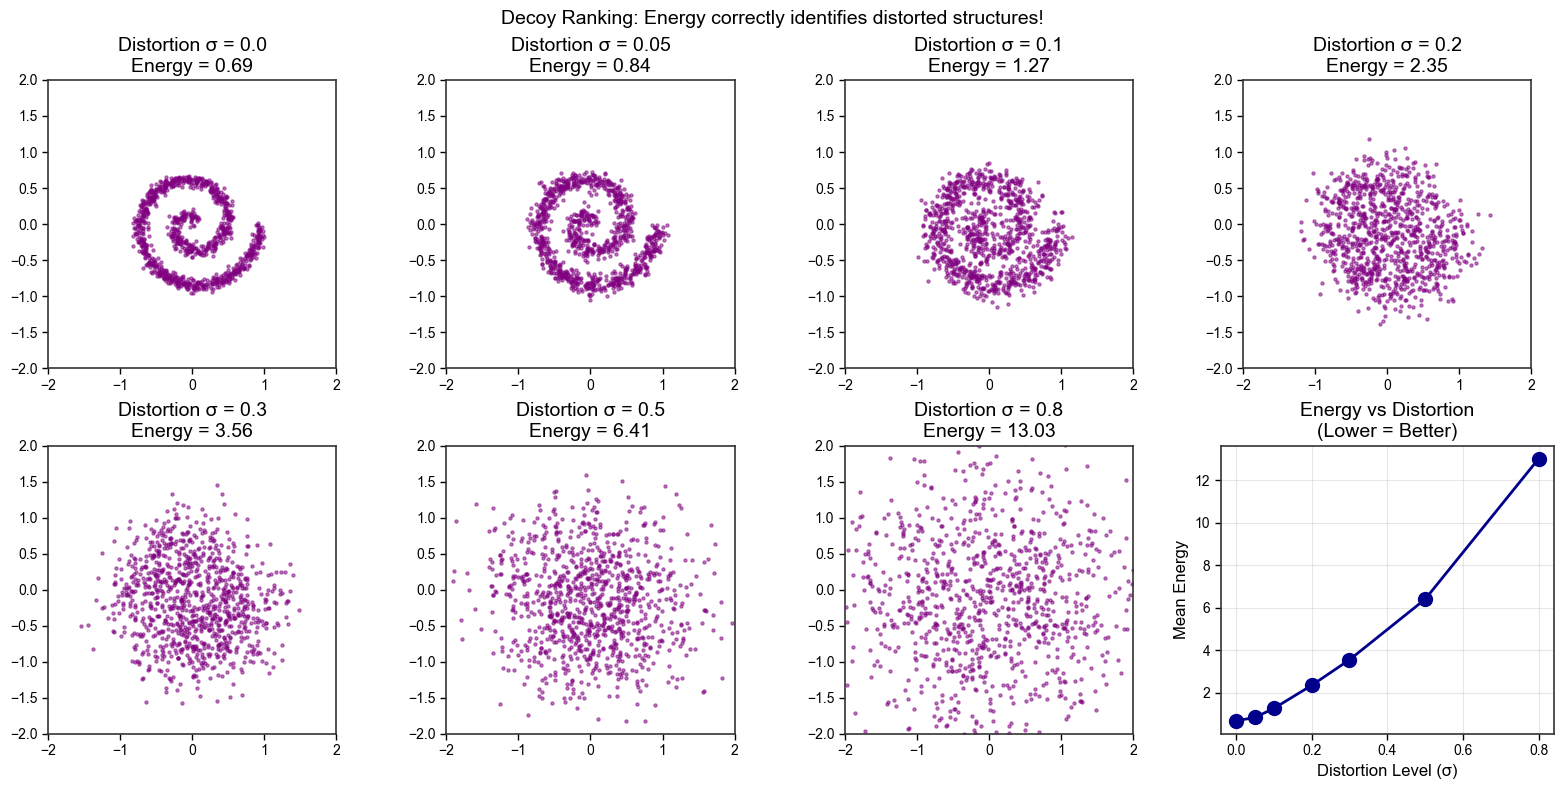

In [89]:
# Visualize decoy ranking
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: Show decoys at different distortion levels
for i, dist in enumerate(distortion_levels[:4]):
    ax = axes[0, i]
    samples = decoys[dist].numpy()
    ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5, c='purple')
    ax.set_title(f'Distortion σ = {dist}\nEnergy = {decoy_energies[dist]:.2f}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')

for i, dist in enumerate(distortion_levels[4:]):
    ax = axes[1, i]
    samples = decoys[dist].numpy()
    ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5, c='purple')
    ax.set_title(f'Distortion σ = {dist}\nEnergy = {decoy_energies[dist]:.2f}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')

# Last subplot: Energy vs Distortion curve
ax = axes[1, 3]
dists = list(decoy_energies.keys())
energies = list(decoy_energies.values())
ax.plot(dists, energies, 'o-', markersize=10, linewidth=2, color='darkblue')
ax.set_xlabel('Distortion Level (σ)')
ax.set_ylabel('Mean Energy')
ax.set_title('Energy vs Distortion\n(Lower = Better)')
ax.grid(True, alpha=0.3)

plt.suptitle('Decoy Ranking: Energy correctly identifies distorted structures!', fontsize=14)
plt.tight_layout()
plt.show()

### Practical Application: Energy-Based Sample Filtering

Now let's apply what we've learned to a practical scenario: **improving generation quality through energy-based filtering**.

**The Strategy:**
1. Generate MORE samples than you need (overgenerate)
2. Score all samples with the energy function
3. Keep only the top-ranked samples (e.g., lowest 20% energy)
4. Discard the rest

This is exactly what ProteinEBM does for protein structure prediction: generate many structure candidates, then use energy to select the most physically plausible ones.

**Why This Works:**
- The sampler explores broadly but imperfectly
- The energy function evaluates accurately
- By combining both, we get better results than sampling alone

Let's implement rejection sampling based on energy:


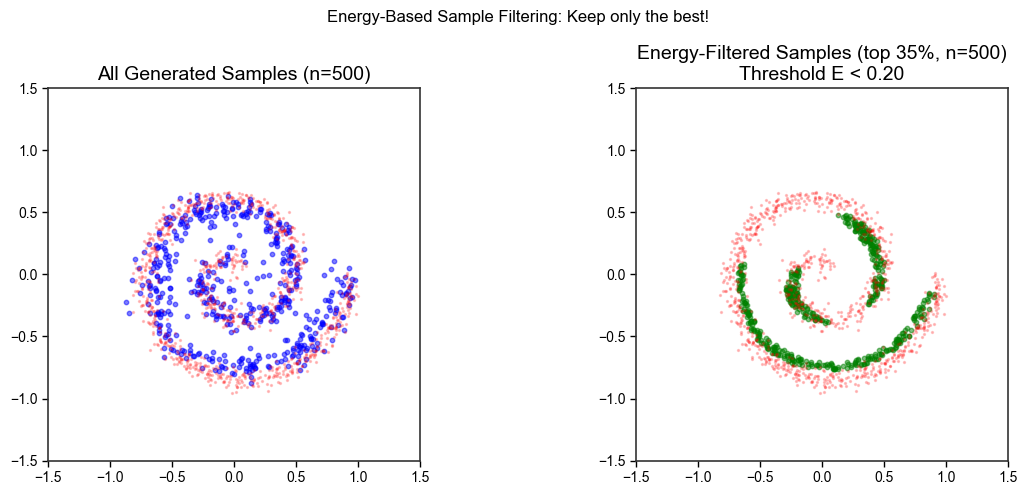

In [109]:

def generate_with_rejection(model, n_desired, timesteps, device, 
                            energy_threshold_percentile=35, t_score=10):
    """
    Generate samples and reject those above an energy threshold.
    This is like how ProteinEBM filters structure predictions.
    
    Args:
        n_desired: number of good samples we want
        energy_threshold_percentile: keep only samples below this percentile
    """
    # Over-generate
    n_generate = int(n_desired * (100 / energy_threshold_percentile) * 1.5)
    
    x_T = torch.randn(n_generate, 2).to(device)
    samples = reverse_diffusion_ebm(model, x_T, timesteps, device=device).cpu()
    energies = score_samples(model, samples, t_value=t_score, device=device)
    
    # Find threshold
    threshold = np.percentile(energies.numpy(), energy_threshold_percentile)
    
    # Filter
    good_mask = energies < threshold
    good_samples = samples[good_mask]
    good_energies = energies[good_mask]
    
    # Take only n_desired
    if len(good_samples) > n_desired:
        good_samples = good_samples[:n_desired]
        good_energies = good_energies[:n_desired]
    
    return good_samples, good_energies, threshold

# Compare: all samples vs filtered samples
n_compare = 500

# All samples (no filtering)
x_T = torch.randn(n_compare, 2).to(device)
all_samples = reverse_diffusion_ebm(model, x_T, timesteps, device=device).cpu()

# Filtered samples (keep best 20%)
filtered_samples, filtered_energies, threshold = generate_with_rejection(
    model, n_compare, timesteps, device, energy_threshold_percentile=35
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(all_samples[:, 0], all_samples[:, 1], s=10, alpha=0.5, c='blue')
axes[0].scatter(data[:, 0], data[:, 1], s=2, c='red', alpha=0.2)
axes[0].set_title(f'All Generated Samples (n={n_compare})')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_aspect('equal')

axes[1].scatter(filtered_samples[:, 0], filtered_samples[:, 1], s=10, alpha=0.5, c='green')
axes[1].scatter(data[:, 0], data[:, 1], s=2, c='red', alpha=0.2)
axes[1].set_title(f'Energy-Filtered Samples (top 35%, n={len(filtered_samples)})\nThreshold E < {threshold:.2f}')
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_aspect('equal')

plt.suptitle('Energy-Based Sample Filtering: Keep only the best!', fontsize=12)
plt.tight_layout()
plt.show()

In [101]:
# =============================================================================
# RANKING COMPLETE STRUCTURES (Spirals), not individual points!
# =============================================================================
# In ProteinEBM, they score entire protein structures (all residue positions).
# Here, each "structure" is a complete spiral (n_points samples).
# We generate multiple spirals and rank them by total/mean energy.
# =============================================================================

def generate_multiple_spirals(model, n_spirals, n_points_per_spiral, timesteps, device):
    """
    Generate multiple independent spiral structures.
    
    Args:
        n_spirals: number of complete spirals to generate
        n_points_per_spiral: points in each spiral (like residues in a protein)
    
    Returns:
        spirals: tensor of shape (n_spirals, n_points_per_spiral, 2)
    """
    model.eval()
    spirals = []
    
    for i in range(n_spirals):
        # Each spiral starts from independent noise
        x_T = torch.randn(n_points_per_spiral, 2).to(device)
        spiral = reverse_diffusion_ebm(model, x_T, timesteps, device=device)
        spirals.append(spiral.cpu())
    
    return torch.stack(spirals)  # (n_spirals, n_points, 2)


def score_spiral_structure(model, spiral, t_value=10, device='cpu'):
    """
    Score a complete spiral structure.
    Returns both total energy and mean energy per point.
    
    In ProteinEBM: E(x, s, t) where x is all residue coordinates.
    Here: sum of energies across all points in the spiral.
    """
    model.eval()
    spiral = spiral.to(device)
    t_batch = torch.full((spiral.shape[0],), t_value, device=device, dtype=torch.long)
    
    with torch.no_grad():
        point_energies, _ = model.compute_energy(spiral, t_batch)
    
    total_energy = point_energies.sum().item()
    mean_energy = point_energies.mean().item()
    
    return total_energy, mean_energy, point_energies.cpu()


def score_multiple_spirals(model, spirals, t_value=10, device='cpu'):
    """
    Score multiple spiral structures and return rankings.
    
    Args:
        spirals: tensor of shape (n_spirals, n_points, 2)
    
    Returns:
        DataFrame with spiral index, total energy, mean energy
    """
    results = []
    
    for i in range(spirals.shape[0]):
        total_e, mean_e, point_energies = score_spiral_structure(
            model, spirals[i], t_value=t_value, device=device
        )
        results.append({
            'spiral_idx': i,
            'total_energy': total_e,
            'mean_energy': mean_e,
            'energy_std': point_energies.std().item()
        })
    
    import pandas as pd
    df = pd.DataFrame(results)
    df = df.sort_values('total_energy').reset_index(drop=True)
    df['rank'] = range(1, len(df) + 1)
    
    return df

## Ranking Complete Structures

So far, we've been scoring individual points. But in many real applications (like protein structure prediction), we want to score **entire structures**. 

**In ProteinEBM:**
- Each "structure" is a complete protein with hundreds of residues
- The energy is computed over all atom positions: $E(x, t) = \sum_i \|r_i(x_i, t)\|^2$
- Multiple predicted structures are ranked by their total or mean energy
- The lowest-energy prediction is selected as the best

**In Our Spiral:**
- Each "structure" is a complete spiral with $n$ points
- We generate multiple independent spirals (different noise initializations)
- We rank them by total energy
- The best spiral should look most like the training data

This is analogous to generating multiple structure predictions and selecting the best one. Let's implement this:


In [ ]:
# =============================================================================
# Generate and rank multiple complete spirals
# =============================================================================

n_spirals = 50  # Generate 50 complete spiral "structures"
n_points_per_spiral = 2000  

print(f"Generating {n_spirals} complete spirals...")
spirals = generate_multiple_spirals(model, n_spirals, n_points_per_spiral, 50, device)
print(f"Generated spirals shape: {spirals.shape}")  # (50, 500, 2)

# Score and rank all spirals
print("Scoring spirals...")
rankings = score_multiple_spirals(model, spirals, t_value=10, device=device)

print("\n" + "=" * 70)
print("SPIRAL STRUCTURE RANKINGS (like ProteinEBM decoy ranking)")
print("=" * 70)
print("\nTop 5 spirals (lowest energy = best):")
print(rankings.head(10).to_string(index=False))
print("\nBottom 5 spirals (highest energy = worst):")
print(rankings.tail(5).to_string(index=False))
print("=" * 70)

Generating 50 complete spirals...
Generated spirals shape: torch.Size([50, 2000, 2])
Scoring spirals...

SPIRAL STRUCTURE RANKINGS (like ProteinEBM decoy ranking)

Top 5 spirals (lowest energy = best):
 spiral_idx  total_energy  mean_energy  energy_std  rank
          9    660.315613     0.330158    0.303882     1
         10    663.993225     0.331997    0.287267     2
         25    664.029907     0.332015    0.306679     3
         28    667.942627     0.333971    0.645719     4
         36    668.226685     0.334113    0.307938     5
         13    668.542480     0.334271    0.691473     6
         39    672.688477     0.336344    0.634322     7
         27    675.681152     0.337841    0.715093     8
          3    681.100952     0.340550    0.652162     9
         19    685.715332     0.342858    0.786599    10

Bottom 5 spirals (highest energy = worst):
 spiral_idx  total_energy  mean_energy  energy_std  rank
         35    803.742859     0.401871    1.507190    46
         48  

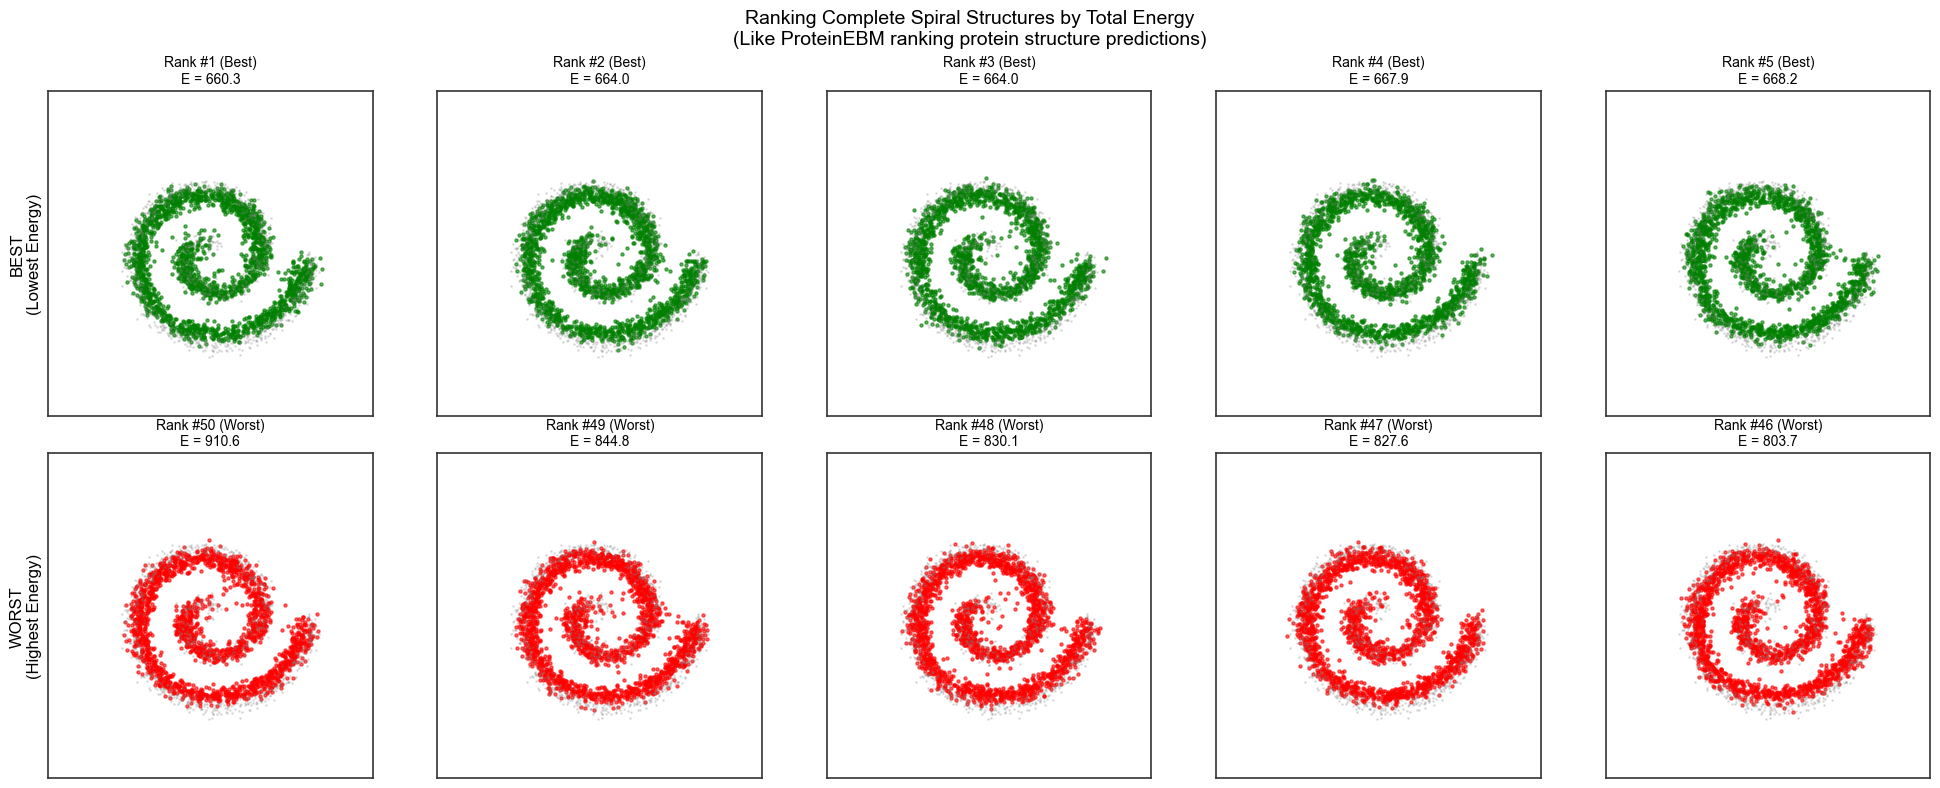

In [107]:
# =============================================================================
# Visualize: Best vs Worst complete spirals
# =============================================================================

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Top row: 5 best spirals
for i in range(5):
    ax = axes[0, i]
    spiral_idx = rankings.iloc[i]['spiral_idx']
    energy = rankings.iloc[i]['total_energy']
    spiral = spirals[int(spiral_idx)].numpy()
    
    ax.scatter(spiral[:, 0], spiral[:, 1], s=5, alpha=0.6, c='green')
    ax.scatter(data[:, 0], data[:, 1], s=1, c='gray', alpha=0.2)
    ax.set_title(f'Rank #{i+1} (Best)\nE = {energy:.1f}', fontsize=10)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# Bottom row: 5 worst spirals
for i in range(5):
    ax = axes[1, i]
    spiral_idx = rankings.iloc[-(i+1)]['spiral_idx']
    energy = rankings.iloc[-(i+1)]['total_energy']
    spiral = spirals[int(spiral_idx)].numpy()
    
    ax.scatter(spiral[:, 0], spiral[:, 1], s=5, alpha=0.6, c='red')
    ax.scatter(data[:, 0], data[:, 1], s=1, c='gray', alpha=0.2)
    ax.set_title(f'Rank #{n_spirals-i} (Worst)\nE = {energy:.1f}', fontsize=10)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_ylabel('BEST\n(Lowest Energy)', fontsize=12)
axes[1, 0].set_ylabel('WORST\n(Highest Energy)', fontsize=12)

plt.suptitle('Ranking Complete Spiral Structures by Total Energy\n(Like ProteinEBM ranking protein structure predictions)', 
             fontsize=14)
plt.tight_layout()
plt.show()

## Final Thoughts: The Power of Energy-Based Diffusion

Congratulations! You've now implemented and explored Energy-Based Diffusion Models, a powerful extension of standard diffusion that combines generation with discrimination.

### Key Concepts We Covered

**1. The Energy Function:**
- Assigns a scalar "energy" to any input: $E(x, t)$
- Low energy = high probability = "good" / "realistic"
- Connected to probability via Boltzmann distribution: $p(x) \propto \exp(-E(x))$

**2. Energy, Score, and Probability:**
- These three quantities are linked: $s(x) = \nabla_x \log p(x) = -\nabla_x E(x)$
- The score (negative energy gradient) points toward higher probability
- We can compute the score via automatic differentiation

**3. Time-Dependent Energy Landscapes:**
- $E(x, t)$ creates a hierarchy of landscapes
- High $t$: smooth, Gaussian-like (global structure)
- Medium $t$: shows data structure (best for scoring)
- Low $t$: sharp, concentrated on manifold (fine details)

**4. Dual Capabilities:**
- **Generation**: Follow the score to denoise samples (like standard diffusion)
- **Discrimination**: Score arbitrary inputs, rank candidates, filter bad samples

**5. Why Discrimination Works:**
- Scoring is a single forward pass (no error accumulation)
- Generation involves hundreds of steps (errors compound)
- Strategy: generate many → rank by energy → keep the best

### The EBM Advantage

Energy-Based Diffusion Models excel when you need:
- **Quality assessment** without ground truth
- **Ranking** multiple candidates
- **Filtering** to improve generation
- **Interpretable** energy landscapes

The ProteinEBM paper demonstrated this beautifully: structure prediction, stability ranking, conformational sampling, and mutation effect prediction—all from one unified energy function.

### When to Use EBM Diffusion

**Use EBM when you need:**
- To score/rank arbitrary inputs (not just your own generations)
- Interpretable energy landscapes
- Physics-grounded modeling (proteins, molecules, materials)
- Stable long-horizon dynamics
- To combine generation with discrimination

**Use standard diffusion when:**
- You only need generation, not scoring
- Speed is critical (EBM has overhead from gradients)
- You don't need the energy interpretation

### Looking Forward

The concepts we've learned here extend far beyond toy 2D spirals:
- **Protein Structure Prediction**: ProteinEBM ranks structure predictions by energy
- **Molecular Design**: Score molecule candidates for drug discovery
- **Materials Science**: Evaluate crystal structures and conformations
- **Conditional Generation**: Combine with guidance for controlled sampling


### Bonus: some cool animated visualization
Use these scripts to see an animated version of the energy landscape and vector field evolving over time.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import numpy as np
from IPython.display import HTML, Image

In [ ]:


def create_energy_landscape_gif(model, data=None, device='cpu', 
                                 grid_size=100, n_frames=60,
                                 t_start=299, t_end=1,
                                 filename='energy_landscape_evolution.gif',
                                 fps=10, dpi=100):
    """
    Create a GIF showing energy landscape evolution over timesteps.
    
    Args:
        model: trained EnergyNetwork
        data: optional training data to overlay
        device: torch device
        grid_size: resolution of energy heatmap
        n_frames: number of frames in the animation
        t_start: starting timestep (high t = noisy)
        t_end: ending timestep (low t = clean)
        filename: output filename
        fps: frames per second
        dpi: resolution
    """
    model.eval()
    
    # Create grid
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    # Generate timesteps (high to low)
    timesteps_to_plot = np.linspace(t_start, t_end, n_frames).astype(int)
    
    # Pre-compute all energy landscapes for consistent colormap
    print("Pre-computing energy landscapes...")
    all_energies = []
    for t_value in timesteps_to_plot:
        t_batch = torch.full((grid_points.shape[0],), t_value, device=device, dtype=torch.long)
        with torch.no_grad():
            energy, _ = model.compute_energy(grid_points, t_batch)
        energy_grid = energy.cpu().numpy().reshape(grid_size, grid_size)
        all_energies.append(energy_grid)
    
    # Find global min/max for consistent colormap
    all_energies_array = np.array(all_energies)
    vmin = np.percentile(all_energies_array, 2)   # Use percentiles to avoid outliers
    vmax = np.percentile(all_energies_array, 98)
    
    print(f"Energy range: {vmin:.2f} to {vmax:.2f}")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Initial plot
    norm = Normalize(vmin=vmin, vmax=vmax)
    contour = ax.contourf(xx.numpy(), yy.numpy(), all_energies[0], 
                          levels=50, cmap='viridis', norm=norm)
    cbar = fig.colorbar(contour, ax=ax, label='Energy E(x, t)')
    
    if data is not None:
        data_scatter = ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.4, 
                                   c='red', label='Training data')
        ax.legend(loc='upper right')
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    title = ax.set_title(f'Energy Landscape at t = {timesteps_to_plot[0]}', fontsize=14)
    
    def update(frame):
        ax.clear()
        
        t_value = timesteps_to_plot[frame]
        energy_grid = all_energies[frame]
        
        # Redraw contour
        contour = ax.contourf(xx.numpy(), yy.numpy(), energy_grid, 
                              levels=50, cmap='viridis', norm=norm)
        
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.4, c='red', label='Training data')
            ax.legend(loc='upper right')
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.set_title(f'Energy Landscape at t = {t_value}\n(High t → Low t: Noise → Data)', fontsize=14)
        
        # Progress indicator
        if frame % 10 == 0:
            print(f"Frame {frame + 1}/{n_frames}")
        
        return [contour]
    
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, update, frames=n_frames, 
                                    interval=1000//fps, blit=False)
    
    # Save as GIF
    print(f"Saving to {filename}...")
    anim.save(filename, writer='pillow', fps=fps, dpi=dpi)
    plt.close()
    
    print(f"Done! Saved to {filename}")
    return filename


# Create the GIF
gif_path = create_energy_landscape_gif(
    model, 
    data=data, 
    device=device,
    grid_size=80,      # Resolution (higher = sharper but slower)
    n_frames=60,       # Number of frames
    t_start=100,       # Start from high t (noisy)
    t_end=1,           # End at low t (clean)
    filename='energy_landscape_evolution.gif',
    fps=5,            # Frames per second
    dpi=100
)

# Display in notebook
Image(filename=gif_path)

In [ ]:
# =============================================================================
# BONUS: Side-by-side GIF with Energy Landscape AND Vector Field
# =============================================================================

def create_dual_evolution_gif(model, data=None, device='cpu',
                               grid_size=80, arrow_grid_size=15, n_frames=50,
                               t_start=299, t_end=1,
                               filename='energy_and_vectorfield_evolution.gif',
                               fps=10, dpi=100):
    """
    Create a GIF showing both energy landscape and vector field evolution.
    """
    model.eval()
    
    # Create grids
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    x_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    y_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    xx_arrow, yy_arrow = torch.meshgrid(x_arrow, y_arrow, indexing='ij')
    arrow_points = torch.stack([xx_arrow.flatten(), yy_arrow.flatten()], dim=1).to(device)
    
    # Generate timesteps
    timesteps_to_plot = np.linspace(t_start, t_end, n_frames).astype(int)
    
    # Pre-compute everything
    print("Pre-computing energy landscapes and vector fields...")
    all_energies = []
    all_scores = []
    
    for i, t_value in enumerate(timesteps_to_plot):
        # Energy landscape
        t_batch = torch.full((grid_points.shape[0],), t_value, device=device, dtype=torch.long)
        with torch.no_grad():
            energy, _ = model.compute_energy(grid_points, t_batch)
        energy_grid = energy.cpu().numpy().reshape(grid_size, grid_size)
        all_energies.append(energy_grid)
        
        # Vector field (needs gradients)
        t_arrow = torch.full((arrow_points.shape[0],), t_value, device=device, dtype=torch.long)
        arrow_points_grad = arrow_points.detach().requires_grad_(True)
        energy_arrow, _ = model.compute_energy(arrow_points_grad, t_arrow)
        grad_energy = torch.autograd.grad(energy_arrow.sum(), arrow_points_grad)[0]
        score = -grad_energy
        all_scores.append(score.detach().cpu().numpy())
        
        if (i + 1) % 10 == 0:
            print(f"  Computed {i + 1}/{n_frames}")
    
    # Find global ranges
    all_energies_array = np.array(all_energies)
    e_vmin = np.percentile(all_energies_array, 2)
    e_vmax = np.percentile(all_energies_array, 98)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    norm = Normalize(vmin=e_vmin, vmax=e_vmax)
    
    def update(frame):
        for ax in axes:
            ax.clear()
        
        t_value = timesteps_to_plot[frame]
        energy_grid = all_energies[frame]
        score = all_scores[frame]
        
        # Left: Energy landscape
        ax = axes[0]
        contour = ax.contourf(xx.numpy(), yy.numpy(), energy_grid,
                              levels=50, cmap='viridis', norm=norm)
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.3, c='red')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Energy Landscape', fontsize=12)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        
        # Right: Vector field
        ax = axes[1]
        score_x = score[:, 0].reshape(arrow_grid_size, arrow_grid_size)
        score_y = score[:, 1].reshape(arrow_grid_size, arrow_grid_size)
        magnitude = np.sqrt(score_x**2 + score_y**2)
        
        # Normalize arrows
        norm_factor = np.maximum(magnitude, 1e-8)
        score_x_norm = score_x / norm_factor * 0.12
        score_y_norm = score_y / norm_factor * 0.12
        
        ax.quiver(xx_arrow.numpy(), yy_arrow.numpy(),
                  score_x_norm, score_y_norm,
                  magnitude, cmap='plasma', alpha=0.8)
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.3, c='lime')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Score Vector Field s(x,t) = -∇E', fontsize=12)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        
        fig.suptitle(f't = {t_value}  (Reverse diffusion: t=299 → t=1)', fontsize=14)
        
        if frame % 10 == 0:
            print(f"Frame {frame + 1}/{n_frames}")
        
        return axes
    
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, update, frames=n_frames,
                                    interval=1000//fps, blit=False)
    
    print(f"Saving to {filename}...")
    anim.save(filename, writer='pillow', fps=fps, dpi=dpi)
    plt.close()
    
    print(f"Done! Saved to {filename}")
    return filename


# Create dual GIF
dual_gif_path = create_dual_evolution_gif(
    model,
    data=data,
    device=device,
    grid_size=80,
    arrow_grid_size=15,
    n_frames=100,
    t_start=80,
    t_end=1,
    filename='energy_and_vectorfield_evolution.gif',
    fps=10,
    dpi=100
)

Image(filename=dual_gif_path)

In [ ]:
# =============================================================================
# BONUS: Side-by-side MP4 with Energy Landscape AND Vector Field
# =============================================================================

def create_dual_evolution_video(model, data=None, device='cpu',
                               grid_size=80, arrow_grid_size=15, n_frames=50,
                               t_start=299, t_end=1,
                               filename='energy_and_vectorfield_evolution.mp4',
                               fps=10, dpi=100):
    """
    Create an MP4 video showing both energy landscape and vector field evolution.
    """
    model.eval()
    
    # Create grids
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    x_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    y_arrow = torch.linspace(-1.4, 1.4, arrow_grid_size)
    xx_arrow, yy_arrow = torch.meshgrid(x_arrow, y_arrow, indexing='ij')
    arrow_points = torch.stack([xx_arrow.flatten(), yy_arrow.flatten()], dim=1).to(device)
    
    # Generate timesteps
    timesteps_to_plot = np.linspace(t_start, t_end, n_frames).astype(int)
    
    # Pre-compute everything
    print("Pre-computing energy landscapes and vector fields...")
    all_energies = []
    all_scores = []
    
    for i, t_value in enumerate(timesteps_to_plot):
        # Energy landscape
        t_batch = torch.full((grid_points.shape[0],), t_value, device=device, dtype=torch.long)
        with torch.no_grad():
            energy, _ = model.compute_energy(grid_points, t_batch)
        energy_grid = energy.cpu().numpy().reshape(grid_size, grid_size)
        all_energies.append(energy_grid)
        
        # Vector field (needs gradients)
        t_arrow = torch.full((arrow_points.shape[0],), t_value, device=device, dtype=torch.long)
        arrow_points_grad = arrow_points.detach().requires_grad_(True)
        energy_arrow, _ = model.compute_energy(arrow_points_grad, t_arrow)
        grad_energy = torch.autograd.grad(energy_arrow.sum(), arrow_points_grad)[0]
        score = -grad_energy
        all_scores.append(score.detach().cpu().numpy())
        
        if (i + 1) % 10 == 0:
            print(f"  Computed {i + 1}/{n_frames}")
    
    # Find global ranges
    all_energies_array = np.array(all_energies)
    e_vmin = np.percentile(all_energies_array, 2)
    e_vmax = np.percentile(all_energies_array, 98)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    norm = Normalize(vmin=e_vmin, vmax=e_vmax)
    
    def update(frame):
        for ax in axes:
            ax.clear()
        
        t_value = timesteps_to_plot[frame]
        energy_grid = all_energies[frame]
        score = all_scores[frame]
        
        # Left: Energy landscape
        ax = axes[0]
        contour = ax.contourf(xx.numpy(), yy.numpy(), energy_grid,
                              levels=50, cmap='viridis', norm=norm)
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.3, c='red')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Energy Landscape', fontsize=12)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        
        # Right: Vector field
        ax = axes[1]
        score_x = score[:, 0].reshape(arrow_grid_size, arrow_grid_size)
        score_y = score[:, 1].reshape(arrow_grid_size, arrow_grid_size)
        magnitude = np.sqrt(score_x**2 + score_y**2)
        
        # Normalize arrows
        norm_factor = np.maximum(magnitude, 1e-8)
        score_x_norm = score_x / norm_factor * 0.12
        score_y_norm = score_y / norm_factor * 0.12
        
        ax.quiver(xx_arrow.numpy(), yy_arrow.numpy(),
                  score_x_norm, score_y_norm,
                  magnitude, cmap='plasma', alpha=0.8)
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.3, c='lime')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Score Vector Field s(x,t) = -∇E', fontsize=12)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        
        fig.suptitle(f't = {t_value}  (Reverse diffusion: t=299 → t=1)', fontsize=14)
        
        if frame % 10 == 0:
            print(f"Frame {frame + 1}/{n_frames}")
        
        return axes
    
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, update, frames=n_frames,
                                    interval=1000//fps, blit=False)
    
    # Save as mp4 using ffmpeg writer
    print(f"Saving to {filename}...")
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Diffusion'), bitrate=1800)
    anim.save(filename, writer=writer, dpi=dpi)
    plt.close()
    
    print(f"Done! Saved to {filename}")
    return filename


# Create dual MP4 video
dual_video_path = create_dual_evolution_video(
    model,
    data=data,
    device=device,
    grid_size=80,
    arrow_grid_size=15,
    n_frames=100,
    t_start=80,
    t_end=1,
    filename='energy_and_vectorfield_evolution.mp4',
    fps=10,
    dpi=100
)

from IPython.display import Video
Video(filename=dual_video_path)

In [ ]:
# =============================================================================
# BONUS 2: Show particles flowing through the energy landscape over time
# =============================================================================
def create_particle_flow_gif(model, n_particles=20, device='cpu',
                              grid_size=80, n_frames=100,
                              filename='particle_flow.gif',
                              fps=15, dpi=100):
    """
    Show particles doing reverse diffusion through the evolving energy landscape.
    """
    model.eval()
    
    # Create grid for energy landscape
    x = torch.linspace(-1.5, 1.5, grid_size)
    y = torch.linspace(-1.5, 1.5, grid_size)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    
    # Initialize particles from noise
    particles = torch.randn(n_particles, 2).to(device)
    
    # Timesteps for reverse diffusion - FIXED!
    total_timesteps = 300
    timesteps = np.linspace(total_timesteps - 1, 0, n_frames).astype(int)
    
    print(f"Timesteps range: {timesteps[0]} → {timesteps[-1]} ({n_frames} frames)")
    
    # Precompute diffusion parameters
    betas = torch.linspace(1e-4, 0.02, total_timesteps, device=device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    print("Running reverse diffusion...")
    
    # Pre-compute energy landscapes and particle positions
    all_energies = []
    all_positions = [particles.cpu().numpy().copy()]
    
    current_particles = particles.clone()
    prev_t = total_timesteps  # Track previous timestep
    
    for frame_idx, t in enumerate(timesteps):
        # Compute energy landscape at this t
        t_batch_grid = torch.full((grid_points.shape[0],), t, device=device, dtype=torch.long)
        with torch.no_grad():
            energy, _ = model.compute_energy(grid_points, t_batch_grid)
        energy_grid = energy.cpu().numpy().reshape(grid_size, grid_size)
        all_energies.append(energy_grid)
        
        # Take reverse diffusion steps from prev_t down to t
        for t_step in range(prev_t - 1, t - 1, -1):
            if t_step < 0:
                break
                
            alpha_t = alphas[t_step]
            alpha_bar_t = alpha_bars[t_step]
            sigma_t = torch.sqrt(betas[t_step])
            
            # Get score
            t_batch = torch.full((n_particles,), t_step, device=device, dtype=torch.long)
            with torch.enable_grad():
                p_grad = current_particles.detach().requires_grad_(True)
                energy_p, _ = model.compute_energy(p_grad, t_batch)
                grad_energy = torch.autograd.grad(energy_p.sum(), p_grad)[0]
                score = -grad_energy
            
            # Reverse step
            z = torch.randn_like(current_particles) if t_step > 0 else torch.zeros_like(current_particles)
            current_particles = (1 / torch.sqrt(alpha_t)) * (
                current_particles + (1 - alpha_t) * score
            ) + sigma_t * z
        
        prev_t = t
        all_positions.append(current_particles.cpu().numpy().copy())
        
        if (frame_idx + 1) % 20 == 0:
            print(f"  Frame {frame_idx + 1}/{n_frames}, t = {t}")
    
    # Find energy range
    all_energies_array = np.array(all_energies)
    e_vmin = np.percentile(all_energies_array, 2)
    e_vmax = np.percentile(all_energies_array, 98)
    norm = Normalize(vmin=e_vmin, vmax=e_vmax)
    
    # Create animation
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Colors for particles
    colors = plt.cm.rainbow(np.linspace(0, 1, n_particles))
    
    def update(frame):
        ax.clear()
        
        t_value = timesteps[frame]
        energy_grid = all_energies[frame]
        positions = all_positions[frame + 1]  # +1 because first position is initial
        
        # Energy landscape
        ax.contourf(xx.numpy(), yy.numpy(), energy_grid,
                    levels=50, cmap='viridis', norm=norm, alpha=0.7)
        
        # Training data
        ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.2, c='white')
        
        # Particle trails (last 10 positions)
        trail_length = min(10, frame + 1)
        for i in range(n_particles):
            trail = np.array([all_positions[max(0, frame + 1 - j)][i] for j in range(trail_length)])
            ax.plot(trail[:, 0], trail[:, 1], '-', color=colors[i], alpha=0.5, linewidth=1)
        
        # Current particle positions
        ax.scatter(positions[:, 0], positions[:, 1], 
                   c=colors, s=100, edgecolor='white', linewidth=2, zorder=10)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.set_title(f'Reverse Diffusion: t = {t_value}\nParticles following score field toward data', 
                     fontsize=12)
        
        if frame % 20 == 0:
            print(f"Rendering frame {frame + 1}/{n_frames}")
        
        return [ax]
    
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, update, frames=n_frames,
                                    interval=1000//fps, blit=False)
    
    print(f"Saving to {filename}...")
    anim.save(filename, writer='pillow', fps=fps, dpi=dpi)
    plt.close()
    
    print(f"Done! Saved to {filename}")
    return filename


# Create particle flow GIF
particle_gif_path = create_particle_flow_gif(
    model,
    n_particles=50,
    device=device,
    grid_size=80,
    n_frames=250,
    filename='particle_flow.gif',
    fps=12,
    dpi=100
)

Image(filename=particle_gif_path)

Timesteps range: 299 → 0 (250 frames)
Running reverse diffusion...
  Frame 20/250, t = 276
  Frame 40/250, t = 252
  Frame 60/250, t = 228
  Frame 80/250, t = 204
  Frame 100/250, t = 180
  Frame 120/250, t = 156
  Frame 140/250, t = 132
  Frame 160/250, t = 108
  Frame 180/250, t = 84
  Frame 200/250, t = 60
  Frame 220/250, t = 36
  Frame 240/250, t = 12
Creating animation...
Saving to particle_flow.gif...
Rendering frame 1/250
Rendering frame 1/250
Rendering frame 21/250
Rendering frame 41/250
Rendering frame 61/250
Rendering frame 81/250
Rendering frame 101/250
Rendering frame 121/250
Rendering frame 141/250
Rendering frame 161/250
Rendering frame 181/250
Rendering frame 201/250
Rendering frame 221/250
Rendering frame 241/250
Done! Saved to particle_flow.gif
